In [1]:
import os
import sys
from pathlib import Path

# setting proper working directory
PROJECT_DIRECTORY = Path(os.path.abspath('')).resolve().parents[0]
sys.path.extend([str(PROJECT_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')
print('Project directory: ', PROJECT_DIRECTORY)

Python 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)] on win32
Project directory:  C:\Users\s8347434\Documents\RecBole-GNN


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import re

In [3]:
# Set global font size and padding
plt.rc('font', size=30)            
plt.rc('axes', titlesize=30, labelsize=30)
plt.rc('axes', labelpad=30) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=18) 

# Define custom colors
tu_dd_blue = (0 / 255, 48 / 255, 93 / 255)
bu_green1 = (138 / 255, 203 / 255, 193 / 255)
bu_green2 = (0 / 255, 172 / 255, 169 / 255)
bu_green3 = (0 / 255, 131 / 255, 141 / 255)
ing_blue1 = (132 / 255, 207 / 255, 237 / 255)
ing_blue2 = (0 / 255, 161 / 255, 217 / 255)
ing_blue3 = (0 / 255, 119 / 255, 174 / 255)
ing_blue4 = (0 / 255, 105 / 255, 180 / 255)

dd_concept_mn_green = (148 / 255, 195 / 255, 86 / 255)
dd_concept_bu_green = (138 / 255, 203 / 255, 193 / 255)
dd_concept_ing_blue = (132 / 207, 119 / 255, 237 / 255)
dd_concept_med_red = (205 / 255, 65 / 255, 44 / 255)
dd_concept_leh_orange = (247 / 255, 169 / 255, 65 / 255)

FILE_DIRECTORY = "../eval/log/EpochEvaluation/"

In [12]:
def plot_training_results(
    log_files,
    plot_mean=False,
    plot_ndgc_alone=False,
    figsize=(14, 7),
    colors=None,
    line_width=2  # Add a parameter to control line width
):
    """
    Parses log files and plots training results (loss and NDCG@10).

    Parameters:
        log_files (dict): A dictionary with model names as keys and log file paths as values.
        plot_mean (bool): Whether to plot the mean across runs or individual runs.
        figsize (tuple): Figure size for the plots.
        colors (dict): Optional list of colors for the plot.
        line_width (int or float): Line width for the plot lines.
    """
    # Function to parse a single log file
    def parse_log_file(file_path, model_name):
        # Regular expressions for extracting information
        training_pattern = re.compile(r"epoch (\d+) training \[time: ([\d.]+)s, train loss: ([\d.]+)\]")
        ndcg_pattern = re.compile(r"ndcg@10 : ([\d.]+)")

        all_data = []
        run_id = 0
        with open(file_path, "r") as f:
            for line in f:
                # Match training info
                training_match = training_pattern.search(line)
                if training_match:
                    epoch, time, train_loss = training_match.groups()
                    epoch = int(epoch) + 1

                    # Calculate run_id and adjusted epoch#
                    if epoch == 1:
                        run_id += 1

                    all_data.append({
                        "model": model_name,
                        "run_id": run_id,
                        "epoch": epoch,
                        "time": float(time),
                        "train_loss": float(train_loss),
                        "ndcg@10": None,
                    })

                # Match NDCG@10 and update the last entry
                ndcg_match = ndcg_pattern.search(line)
                if ndcg_match and all_data:
                    all_data[-1]["ndcg@10"] = float(ndcg_match.group(1))

        return pd.DataFrame(all_data)

    # Parse log files and combine data
    df_combined = pd.concat(
        [parse_log_file(file_path, model_name) for model_name, file_path in log_files.items()],
        ignore_index=True,
    )
    
    # Create custom legend handles for consistent line styles and colors
    legend_handles = [
        Line2D([0], [0], color=colors[model], lw=2, label=model)
        for model in df_combined["model"].unique()
    ]

    # Plotting
    plt.figure(figsize=figsize)
    num_models = len(df_combined["model"].unique())

    if num_models == 1 and not plot_ndgc_alone:
        if plot_mean:
            # Plot Mean Train Loss
            plt.subplot(1, 2, 1)
            for model, df_model in df_combined.groupby("model"):
                df_loss = df_model.groupby("epoch")["train_loss"].mean()
                sns.lineplot(data=df_loss, label=f"{model} Mean Train Loss", linewidth=line_width, color=colors.get(model, "black"))
            plt.ylabel("NDCG@10", fontsize=25, labelpad=10)

            # Plot Mean NDCG@10
            plt.subplot(1, 2, 2)
            for model, df_model in df_combined.groupby("model"):
                df_ndcg = df_model.dropna(subset=["ndcg@10"]).groupby("epoch")["ndcg@10"].mean()
                sns.lineplot(data=df_ndcg, label=f"{model} Mean NDCG@10", linewidth=line_width, color=colors.get(model, "black"))
            plt.ylabel("NDCG@10", fontsize=25, labelpad=10)
            
            ax = plt.gca()  # Get current axes
            for spine in ax.spines.values():
                spine.set_edgecolor('black')  # Set the color of the border
                spine.set_linewidth(1)  # Set the thickness of the border
                
            # Customize ticks
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
                    
            plt.minorticks_on()
            plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.3, color='gray')
        
            # Add the legend with transparency
            plt.legend(
                handles=legend_handles,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.2),  # Adjusted position
                ncol=num_models,
                fontsize=20,
                framealpha=0.4  # Transparent legend background
            )
        
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.3)
            
            
        else:
            # Plot Train Loss for individual runs
            plt.subplot(1, 2, 1)
            for model, df_model in df_combined.groupby("model"):
                for run_id, df_run in df_model.groupby("run_id"):
                    sns.lineplot(data=df_run, x="epoch", y="train_loss", label=f"{model} Run {run_id} Train Loss", alpha=0.5, linewidth=line_width, color=colors.get(model, "black"))
            plt.ylabel("Train Loss", fontsize=25, labelpad=10)

            # Plot NDCG@10 for individual runs
            plt.subplot(1, 2, 2)
            for model, df_model in df_combined.groupby("model"):
                for run_id, df_run in df_model.groupby("run_id"):
                    df_run = df_run.dropna(subset=["ndcg@10"])
                    sns.lineplot(data=df_run, x="epoch", y="ndcg@10", label=f"{model} Run {run_id} NDCG@10", alpha=0.5, linewidth=line_width, color=colors.get(model, "black"))
            plt.ylabel("NDCG@10", fontsize=25, labelpad=10)
            plt.xlabel("Epoch", fontsize=25, labelpad=10)
            
            ax = plt.gca()  # Get current axes
            for spine in ax.spines.values():
                spine.set_edgecolor('black')  # Set the color of the border
                spine.set_linewidth(1)  # Set the thickness of the border
                
            # Customize ticks
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
                    
            plt.minorticks_on()
            plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.3, color='gray')
        
            # Add the legend with transparency
            plt.legend(
                handles=legend_handles,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.2),  # Adjusted position
                ncol=num_models,
                fontsize=20,
                framealpha=0.4  # Transparent legend background
            )
        
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.3)






    elif num_models >= 2 or plot_ndgc_alone:
        if plot_mean:
            # Plot Mean NDCG@10 for all models
            for model, df_model in df_combined.groupby("model"):
                df_ndcg = df_model.dropna(subset=["ndcg@10"]).groupby("epoch")["ndcg@10"].mean()
                sns.lineplot(data=df_ndcg, label=f"{model} Mean NDCG@10", linewidth=line_width, color=colors.get(model, "black"))
            plt.ylabel("NDCG@10", fontsize=25, labelpad=10)
        else:
            # Plot NDCG@10 for individual runs
            for model, df_model in df_combined.groupby("model"):
                for run_id, df_run in df_model.groupby("run_id"):
                    df_run = df_run.dropna(subset=["ndcg@10"])
                    sns.lineplot(data=df_run, x="epoch", y="ndcg@10", label=f"{model} Run {run_id} NDCG@10", color=colors.get(model, "black"), alpha=0.5, linewidth=line_width)
            plt.ylabel("NDCG@10", fontsize=25, labelpad=10)
            
            
            plt.xlabel("Epoch", fontsize=25, labelpad=10)
            
            ax = plt.gca()  # Get current axes
            for spine in ax.spines.values():
                spine.set_edgecolor('black')  # Set the color of the border
                spine.set_linewidth(1)  # Set the thickness of the border
                
            # Customize ticks
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
                    
            plt.minorticks_on()
            plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.3, color='gray')
        
            # Add the legend with transparency
            plt.legend(
                handles=legend_handles,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.2),  # Adjusted position
                ncol=num_models,
                fontsize=20,
                framealpha=0.4  # Transparent legend background
            )
        
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.3)

    if num_models == 1:
        plt.savefig(f"../asset/plots/epoch_evaluation_{df_combined["model"].unique()}.png", dpi=300, transparent=True, bbox_inches='tight')
    else:
        plt.savefig(f"../asset/plots/epoch_evaluation_{'_'.join(model for model in df_combined["model"].unique())}.png", dpi=300, transparent=True, bbox_inches='tight')

    plt.show()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


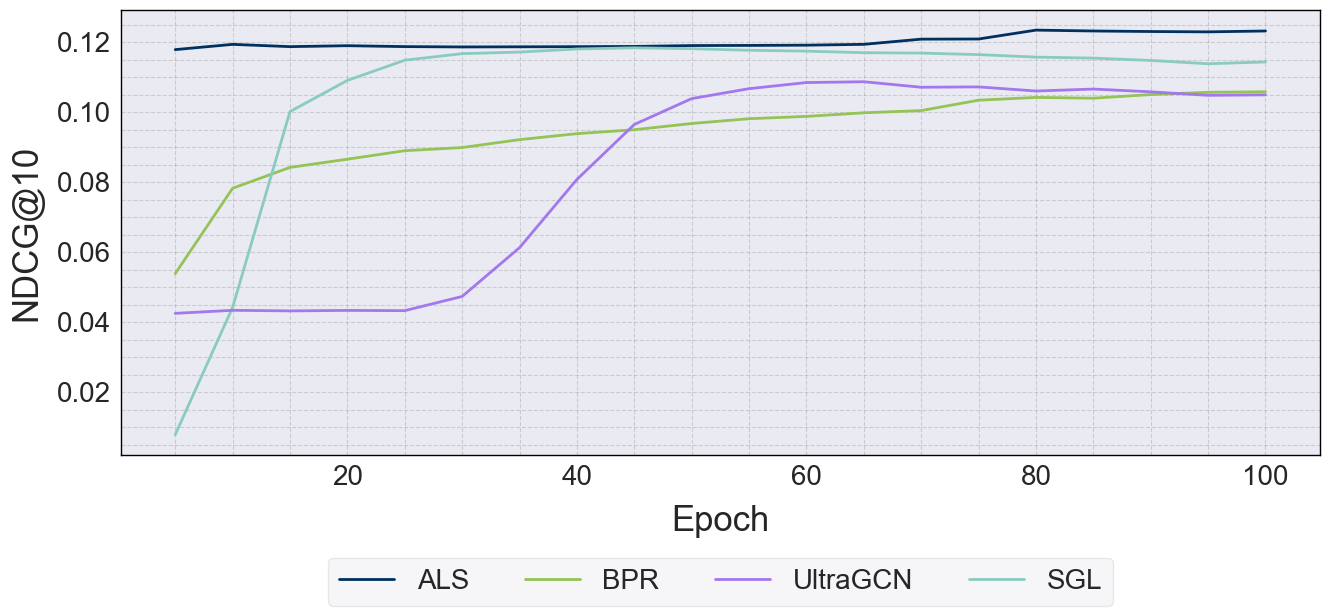

In [10]:
log_files = {
    "ALS": FILE_DIRECTORY + "ALS-RandomSearch.log",
    "BPR": FILE_DIRECTORY + "BPR-RandomSearch.log",
    #"LightGCN": FILE_DIRECTORY + "LightGCN-RandomSearch.log",
    "UltraGCN": FILE_DIRECTORY + "UltraGCN-RandomSearch.log",
    "SGL": FILE_DIRECTORY + "SGL-RandomSearch.log",
    "XSimGCL": FILE_DIRECTORY + "XSimGCL-RandomSearch.log",
}

colors = [tu_dd_blue, dd_concept_mn_green, dd_concept_ing_blue, dd_concept_leh_orange]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=len(log_files))
palette = [cmap(i / (len(log_files))) for i in range(len(log_files))]

# Define custom colors
colors = {
    "ALS": tu_dd_blue,
    "BPR": dd_concept_mn_green,
    "LightGCN": dd_concept_leh_orange,
    "UltraGCN": dd_concept_ing_blue,
    "SGL": dd_concept_bu_green,
    "XSimGCL": dd_concept_med_red
}

plot_training_results(
    log_files=log_files,
    plot_mean=True,
    plot_ndgc_alone=False,
    figsize=(14, 7),
    colors=colors,
    line_width=2
)

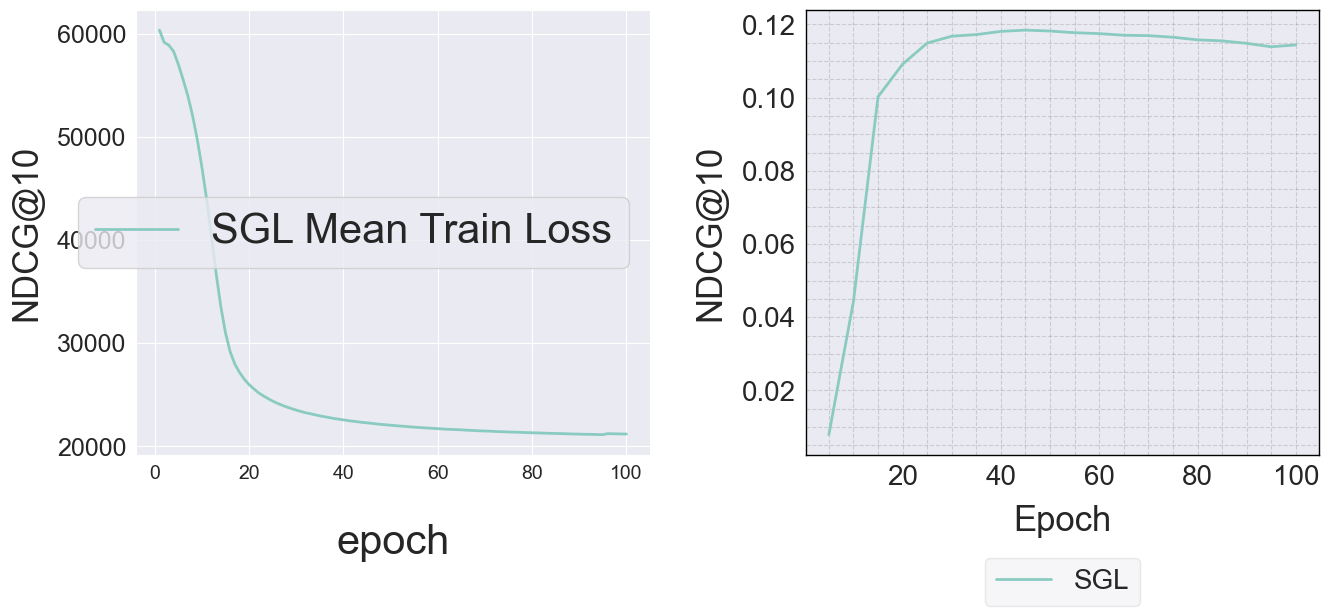

In [11]:
log_files = {
    #"ALS": FILE_DIRECTORY + "ALS-RandomSearch.log",
    #"BPR": FILE_DIRECTORY + "BPR-RandomSearch.log",
    #"LightGCN": FILE_DIRECTORY + "LightGCN-RandomSearch.log",
    #"UltraGCN": FILE_DIRECTORY + "UltraGCN-RandomSearch.log",
    "SGL": FILE_DIRECTORY + "SGL-RandomSearch.log",
    #"XSimGCL": FILE_DIRECTORY + "XSimGCL-RandomSearch.log",
}

colors = [tu_dd_blue, dd_concept_mn_green, dd_concept_ing_blue, dd_concept_leh_orange]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=len(log_files))
palette = [cmap(i / (len(log_files))) for i in range(len(log_files))]

# Define custom colors
colors = {
    "ALS": tu_dd_blue,
    "BPR": dd_concept_mn_green,
    "LightGCN": dd_concept_leh_orange,
    "UltraGCN": dd_concept_ing_blue,
    "SGL": dd_concept_bu_green,
    "XSimGCL": dd_concept_med_red
}

plot_training_results(
    log_files=log_files,
    plot_mean=True,
    plot_ndgc_alone=False,
    figsize=(14, 7),
    colors=colors,
    line_width=2
)